In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In this notebook, we will explore several types of Regression models on a Medical Cost dataset found on Kaggle( https://www.kaggle.com/mirichoi0218/insurance ) to see if we can predict if certain factors can predict medical costs. This data set shows individual medical costs as billed by insurance. The identity of each individual is hidden but some personal data is given such as: age, sex, BMI, how many children they have, if they are as smoker, and what region they are from. We have no data on the diagnosis of patients. But we have other information that can help us to make a conclusion about the health of patients and practice regression analysis.

Let's Start With Exploratory Data Analysis (EDA)!

In [2]:
#Load data
csv_url = 'https://raw.githubusercontent.com/mkung8889/ML_Regression/master/insurance.csv'
df = pd.read_csv(csv_url)

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
#Check for any null values
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

There is no NaN values, so no need to use SciKit Imputer to handle missing data in the dataset.

## Let's Start some EDA: 
### Medical Charges:
Let's first take a look at "charges"

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64


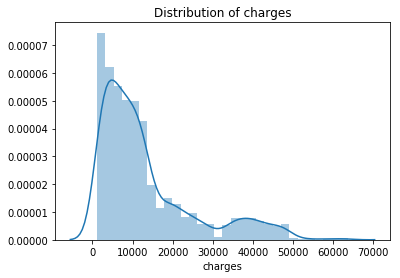

In [5]:
print(df.charges.describe())
sns.distplot(df.charges)
plt.title('Distribution of charges')
plt.show()

We can see there is quite a range of charges, from 1121.8 all the way to 63770.42. There is a right skewed distribution where a large majority of charges are 16,639.91 or lower (We will normalize 'charges' with logarithms later before we start modeling).

Now lets look at correlation between features!

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df['sex'] = le.fit_transform(df['sex'])
df['smoker'] = le.fit_transform(df['smoker'])
df['region'] = le.fit_transform(df['region'])

In [7]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


In [8]:
df.corr()['charges'].sort_values(ascending=False)

charges     1.000000
smoker      0.787251
age         0.299008
bmi         0.198341
children    0.067998
sex         0.057292
region     -0.006208
Name: charges, dtype: float64

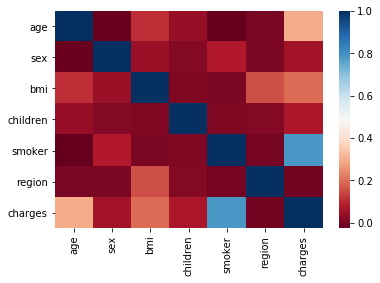

In [9]:
sns.heatmap(df.corr(), cmap='RdBu')

We see there is a strong correlation between 'smoker' and 'charges'. I would have expected bmi to also be highly correlated to charges.

### Smoker Analysis:
Let's start with the most correlated feature and taking a deeper look into 'smoker'.

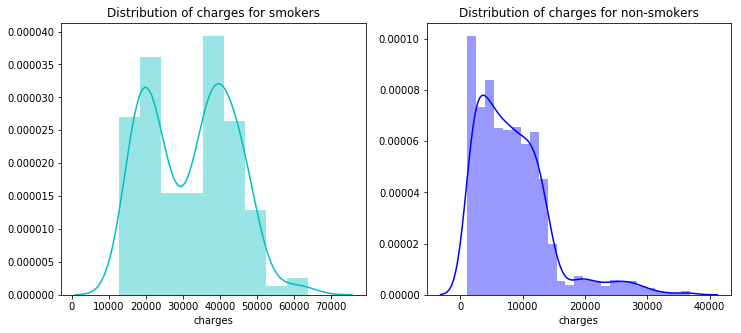

In [10]:
f= plt.figure(figsize=(12,5))

ax1=f.add_subplot(121)
sns.distplot(df[(df.smoker == 1)]["charges"],color='c',ax=ax1)
ax1.set_title('Distribution of charges for smokers')

ax2=f.add_subplot(122)
sns.distplot(df[(df.smoker == 0)]['charges'],color='b',ax=ax2)
ax2.set_title('Distribution of charges for non-smokers')
plt.show()

We can see smokers' charge range much higher than non-smokers. But lets see how many smokers and non-smokers there are.

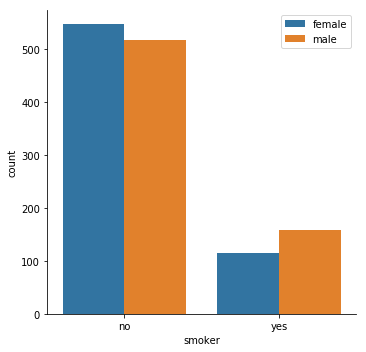

In [11]:
sns.catplot(x='smoker',hue='sex', kind='count', legend=False, data=df)
plt.xticks(np.arange(2), labels=['no', 'yes'])
plt.legend(labels=('female', 'male'))
plt.show()

We can see there are much more non-smokers than smokers. We can also see there are more male smokers than female.

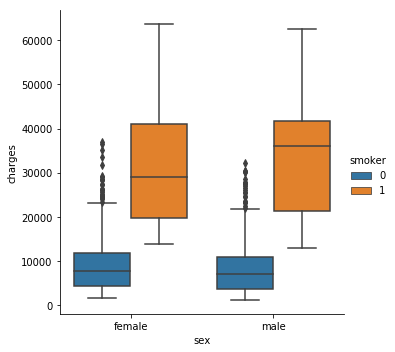

In [12]:
sns.catplot(x="sex", y="charges", hue="smoker", kind="box", data=df)
plt.xticks(np.arange(0,2),["female","male"])
plt.show()

Here we see that, smokers indeed have the higher charges independent of sex. There is not much difference in the boxplot between female and male smoker charges besides different medians.  As expected there are outliers in the non-smoker group who have higher medical charges, possibly due to accidents or serious disease etc. 

Now that we have looked closer at the smoker feature, lets start looking into the next most correlated feature in regards to 'charges'.

### Age Analysis:

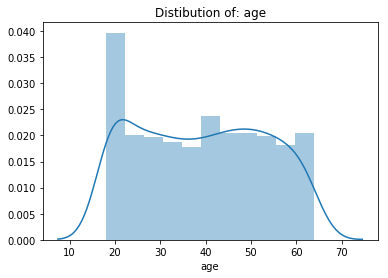

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

young adult (18-35): 574
senior adult (36-53): 494
elder (54+): 270

age 18: 69
age 19: 68
age 20: 29
age 21: 28


In [16]:
sns.distplot(df.age)
plt.title('Distibution of: age')
plt.show()
print(df.age.describe())
print("")
young_adult = df.loc[(df['age']>=18) & (df['age']<=35)]
senior_adult = df.loc[(df['age']>=36) & (df['age']<=53)]
elder = df.loc[(df['age']>=54)]

print("""young adult (18-35): {}
senior adult (36-53): {}
elder (54+): {}
""".format(young_adult['age'].count(), 
           senior_adult['age'].count(), 
           elder['age'].count()
          ))

for i in range(18,22):
    print('age {}:'.format(i), df['age'].loc[df['age']==i].count())

We see the age range is 18 to 64 with a mean age of 39. There are more much more 18 and 19 year olds than any other age.  If we categorize the ages into three groups [young adult (18-35), senior adult (36-53), elder (54+)], we can see there are much less elder patient data. If more patient data who are 54+ years old, we may have seen a different 'charges' distribution. 

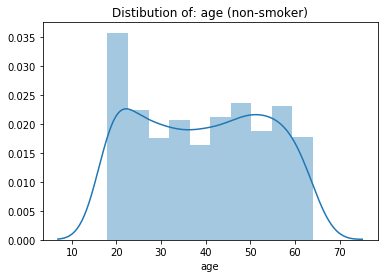

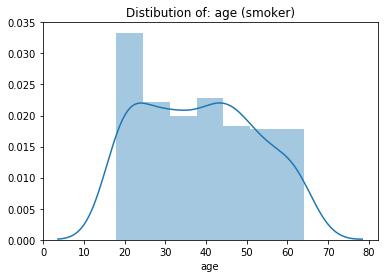

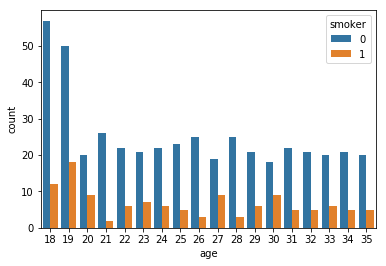

In [37]:
sns.distplot(df.loc[df['smoker']==0]['age'])
plt.title('Distibution of: age (non-smoker)')
plt.show()
sns.distplot(df.loc[df['smoker']==1]['age'])
plt.title('Distibution of: age (smoker)')
plt.show()
sns.countplot(x='age',hue='smoker',data=young_adult)
plt.show()

We see that the age with the most smokers is 19 years old.

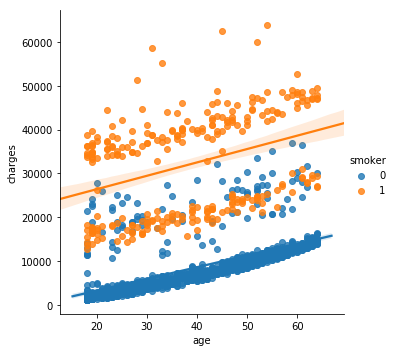

In [35]:
sns.lmplot(x='age', y='charges',hue='smoker', data=df)
plt.show()

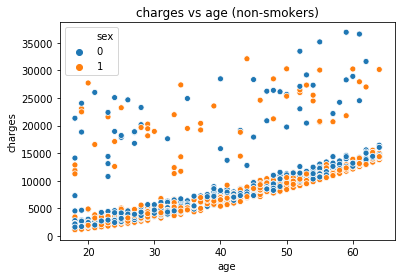

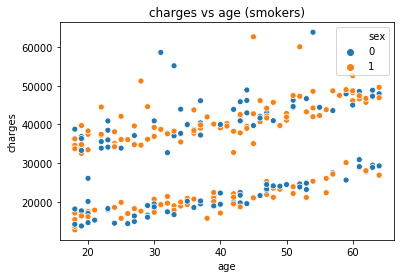

In [67]:
#non-smokers
sns.scatterplot(x=df.loc[df.smoker == 0].age, y=df.loc[df.smoker == 0].charges, hue='sex', data=df)
plt.title("charges vs age (non-smokers)")
plt.show()

#smokers
sns.scatterplot(x=df.loc[df.smoker == 1].age, y=df.loc[df.smoker == 1].charges, hue='sex', data=df)
plt.title("charges vs age (smokers)")
plt.show()

We can see a trend in non-smokers that as patients age increased so does their insurance charges.

Smokers see a similar trend with a major difference. The orange regression line splits the smoker group into two groups: smokers with charges less than 30,000 or above 30,000. The smokers with the lower charges out of all the smokers are in the same charges range as the outlier non-smokers. 

The split between smokers is very interesting. This could be simply due to the peculiarities of this dataset and how this data for this dataset was obtained. Or maybe this split is due to another feature.

As we saw before, sex does not seem to play a part in charges in relation to age for either non-smokers or smokers.

### BMI analysis:
Now let's take a look at BMI.

According to the American Cancer Society (https://www.cancer.org/cancer/cancer-causes/diet-physical-activity/body-weight-and-cancer-risk/adult-bmi.html):
- Underweight: BMI is less than 18.5
- Normal weight: BMI is 18.5 to 24.9
- Overweight: BMI is 25 to 29.9
- Obese: BMI is 30 or more

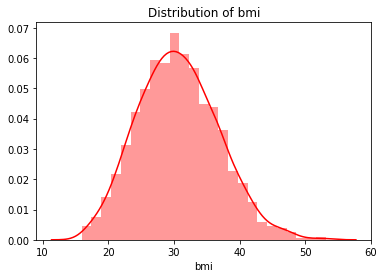

In [62]:
sns.distplot(df.bmi, color='red')
plt.title('Distribution of bmi')
plt.show()

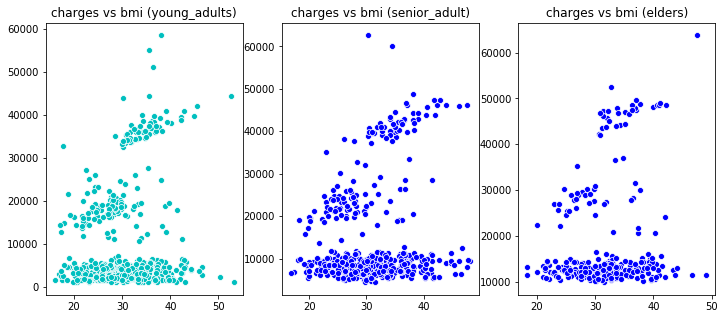

In [69]:
f= plt.figure(figsize=(12,5))

ax1=f.add_subplot(131)
sns.scatterplot(x=young_adult['bmi'].values, y=young_adult['charges'].values,color='c',ax=ax1)
ax1.set_title('charges vs bmi (young_adults)')

ax2=f.add_subplot(132)
sns.scatterplot(x=senior_adult['bmi'].values, y=senior_adult['charges'].values,color='b',ax=ax2)
ax2.set_title('charges vs bmi (senior_adult)')

ax3=f.add_subplot(133)
sns.scatterplot(x=elder['bmi'].values, y=elder['charges'].values,color='b',ax=ax3)
ax3.set_title('charges vs bmi (elders)')
plt.show()

We see BMI has a almost perfect normal disctribution. There is no difference in charges related to bmi between young-adults, senior-adults, and elders. 

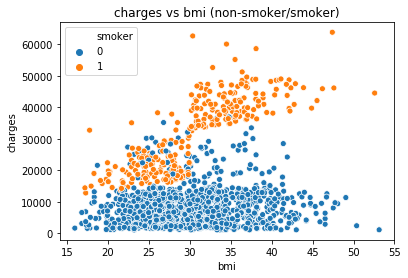

In [71]:
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df)
plt.title('charges vs bmi (non-smoker/smoker)')
plt.show()

We also see that smokers who are obese (BMI>=30) spend much more treatment than smokers who are not obese (BMI<30). This could explain the split in smokers in our 'charges vs age' graph in the previous section.

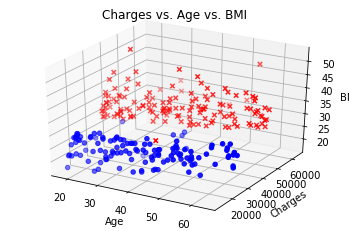

In [89]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=df.loc[(df.smoker==1) & (df.bmi<30)].age, ys=df.loc[(df.smoker==1) & (df.bmi<30)].charges, zs=df.loc[(df.smoker==1) & (df.bmi<30)].bmi, c='b', marker='o')
ax.scatter(xs=df.loc[(df.smoker==1) & (df.bmi>=30)].age, ys=df.loc[(df.smoker==1) & (df.bmi>=30)].charges, zs=df.loc[(df.smoker==1) & (df.bmi>=30)].bmi, c='r', marker='x')
plt.title('Charges vs. Age vs. BMI')
ax.set_xlabel('Age')
ax.set_ylabel('Charges')
ax.set_zlabel('BMI')
plt.show()

This 3D plot (Charges vs. Age vs. BMI) shows that the split in the 'Charges vs Age' graph as well as the split in the 'Charges vs BMI' graph. 

### Number of Children + Region Analysis:
Lastly, let's look at the number of children patients have and region patients are in.

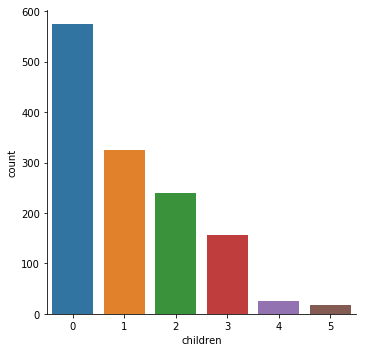

In [90]:
sns.catplot(x='children', kind='count', data=df)
plt.show()

The are much more patients who do not have children, which is expected because there are much more 18 and 19 year olds patients in this dataset than any other age.

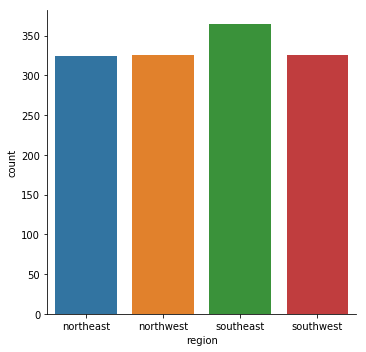

In [97]:
sns.catplot(x='region', kind='count', data=df)
plt.xticks(np.arange(4),labels=['northeast','northwest','southeast','southwest'])
plt.show()

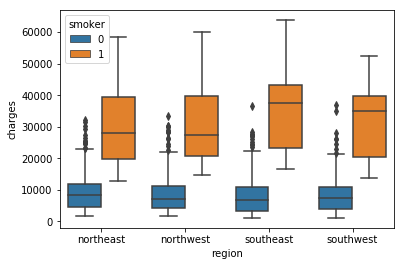

In [98]:
sns.boxplot(x='region', y='charges',hue='smoker', data=df)
plt.xticks(np.arange(4),labels=['northeast','northwest','southeast','southwest'])
plt.show()

There is no real difference between regions and the number of patients from each region is about the same.

## Let's Start Modeling!

We are going to look at multiple different regression models:
- Multiple Linear Regression
- Polynomial Linear Regression
- Decision Tree Regression
- Random Forest Regresssion

### First, Preprocessing!


Let's first set our X and y variables

In [99]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


In [100]:
X = df.iloc[:,:-1].values
y = df['charges'].values

In [101]:
print(X[:5])
print(y[:5])

[[19.     0.    27.9    0.     1.     3.   ]
 [18.     1.    33.77   1.     0.     2.   ]
 [28.     1.    33.     3.     0.     2.   ]
 [33.     1.    22.705  0.     0.     1.   ]
 [32.     1.    28.88   0.     0.     1.   ]]
[16884.924    1725.5523   4449.462   21984.47061  3866.8552 ]


We need to use LabelEncoder for all the categorical features ('sex', 'smoker', 'region') and use OneHotEncoder for the 'region' feature.

In [102]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# le_X = LabelEncoder()
# X[:, 1] = le_X.fit_transform(X[:,1])
# X[:, 4] = le_X.fit_transform(X[:,4])
# X[:, 5] = le_X.fit_transform(X[:,5])
ohe = OneHotEncoder(categorical_features=[5])
X = ohe.fit_transform(X).toarray()
X = X[:,1:]

C:\Users\Office fdpa\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:392: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [103]:
print(X[:5])

[[ 0.     0.     1.    19.     0.    27.9    0.     1.   ]
 [ 0.     1.     0.    18.     1.    33.77   1.     0.   ]
 [ 0.     1.     0.    28.     1.    33.     3.     0.   ]
 [ 1.     0.     0.    33.     1.    22.705  0.     0.   ]
 [ 1.     0.     0.    32.     1.    28.88   0.     0.   ]]


In [104]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X[:,[3,5,6]] = sc_X.fit_transform(X[:,[3,5,6]])
y = sc_y.fit_transform(y.reshape(-1, 1))

In [105]:
#Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1070, 8) (268, 8) (1070, 1) (268, 1)


### Multiple Linear Regression

In [106]:
# Fitting Multiple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
multilr = LinearRegression()
multilr.fit(X_train, y_train)

# Predicting the Test set results
multilr_pred = multilr.predict(X_test)
multilr_pred_train = multilr.predict(X_train)

multilr_score = multilr.score(X_test, y_test)
multilr_score_train = multilr.score(X_train, y_train)
print("""Multiple Linear Regression R2 Score: 
train: {}
test: {}""".format(multilr_score_train, multilr_score))

Multiple Linear Regression R2 Score: 
train: 0.7370262574551634
test: 0.7999876970680434


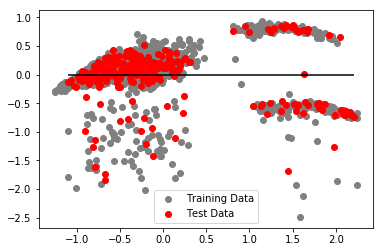

In [107]:
plt.scatter(multilr_pred_train, multilr_pred_train-y_train, color='gray', label='Training Data')
plt.scatter(multilr_pred, multilr_pred-y_test, color='red', label='Test Data')
plt.hlines(y=0, xmin=multilr_pred.min(), xmax=multilr_pred.max())
plt.legend()
plt.show()

### Polynomial Regression

In [108]:
from sklearn.preprocessing import PolynomialFeatures
#poly = PolynomialFeatures(degree=2)
#poly = PolynomialFeatures(degree=3)
#poly = PolynomialFeatures(degree=4)
#poly = PolynomialFeatures(degree=5)
poly = PolynomialFeatures(degree=6)
X_poly = poly.fit_transform(X)
X_test_poly = poly.fit_transform(X_test)
X_train_poly = poly.fit_transform(X_train)
polylr = LinearRegression()
polylr.fit(X_poly, y)
poly_pred = polylr.predict(X_test_poly)
poly_pred_train = polylr.predict(X_train_poly)

polylr_score = polylr.score(X_test_poly, y_test)
polylr_score_train = polylr.score(X_train_poly, y_train)
print("""Polynomial Linear Regression R2 Score: 
train: {}
test: {}""".format(polylr_score_train, polylr_score))

Polynomial Linear Regression R2 Score: 
train: 0.9284656026927763
test: 0.9431174924745842


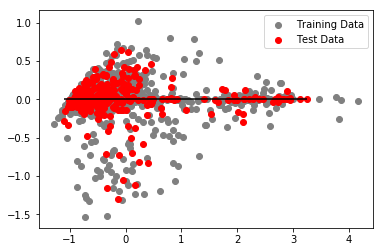

In [109]:
plt.scatter(poly_pred_train, poly_pred_train-y_train, color='gray', label='Training Data')
plt.scatter(poly_pred, poly_pred-y_test, color='red', label='Test Data')
plt.hlines(y=0, xmin=poly_pred.min(), xmax=poly_pred.max())
plt.legend()
plt.show()

### Support Vector Regression (SVR):

In [110]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf')
svr.fit(X, y)
svr_pred = svr.predict(X_test)
svr_pred_train = svr.predict(X_train)
svr_score = svr.score(X_test, y_test)
svr_score_train = svr.score(X_train, y_train)
print("""Multiple Linear Regression R2 Score: 
train: {}
test: {}""".format(svr_score_train, svr_score))

Multiple Linear Regression R2 Score: 
train: 0.836962588385416
test: 0.8946542176782867


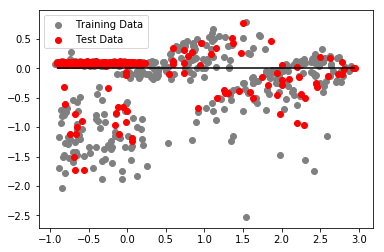

In [111]:
plt.scatter(svr_pred_train.reshape(-1,1), svr_pred_train.reshape(-1,1)-y_train, color='gray', label='Training Data')
plt.scatter(svr_pred.reshape(-1,1), svr_pred.reshape(-1,1)-y_test, color='red', label='Test Data')
plt.hlines(y=0, xmin=svr_pred.min(), xmax=svr_pred.max())
plt.legend()
plt.show()

### Decision Tree:

In [112]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=0)
dtr.fit(X,y)
dtr_pred = dtr.predict(X_test)
dtr_pred_train = dtr.predict(X_train)
dtr_score = dtr.score(X_test, y_test)
dtr_score_train = dtr.score(X_train, y_train)
print("""Multiple Linear Regression R2 Score: 
train: {}
test: {}""".format(dtr_score_train, dtr_score))

Multiple Linear Regression R2 Score: 
train: 0.9982963879446651
test: 0.9999999957255441


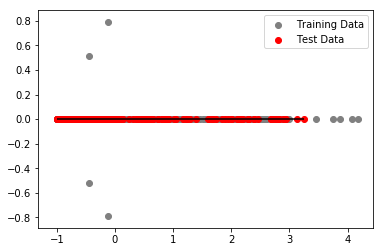

In [113]:
plt.scatter(dtr_pred_train.reshape(-1,1), dtr_pred_train.reshape(-1,1)-y_train, color='gray', label='Training Data')
plt.scatter(dtr_pred.reshape(-1,1), dtr_pred.reshape(-1,1)-y_test, color='red', label='Test Data')
plt.hlines(y=0, xmin=dtr_pred.min(), xmax=dtr_pred.max())
plt.legend()
plt.show()

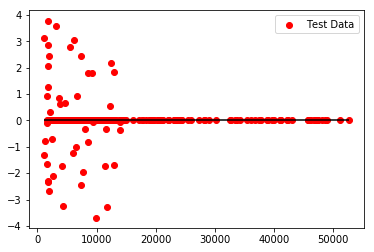

In [114]:
# plt.scatter(sc_y.inverse_transform(dtr_pred_train), sc_y.inverse_transform(dtr_pred_train.reshape(-1,1))-sc_y.inverse_transform(y_train), color='gray', label='Training Data')
plt.scatter(sc_y.inverse_transform(dtr_pred), sc_y.inverse_transform(dtr_pred.reshape(-1,1))-sc_y.inverse_transform(y_test), color='red', label='Test Data')
plt.hlines(y=0, xmin=sc_y.inverse_transform(dtr_pred.reshape(-1,1)).min(), xmax=sc_y.inverse_transform(dtr_pred.reshape(-1,1)).max())
plt.legend()
plt.show()

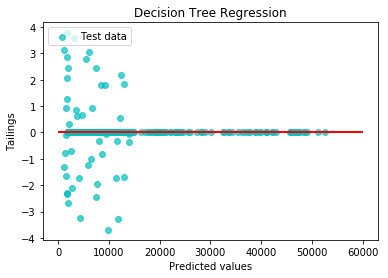

In [115]:
plt.scatter(sc_y.inverse_transform(dtr_pred), 
            sc_y.inverse_transform(dtr_pred.reshape(-1,1)) - sc_y.inverse_transform(y_test),
            c = 'c', marker = 'o', s = 35, alpha = 0.7,
            label = 'Test data')
plt.title('Decision Tree Regression')
plt.xlabel('Predicted values')
plt.ylabel('Tailings')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = 0, xmax = 60000, lw = 2, color = 'red')
plt.show()

### Random Forest Regression:

In [116]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=10,
                            criterion='mse')
rfr.fit(X,y)
rfr_pred = rfr.predict(X_test)
rfr_pred_train = rfr.predict(X_train)
rfr_score = rfr.score(X_test, y_test)
rfr_score_train = rfr.score(X_train, y_train)
print("""Multiple Linear Regression R2 Score: 
train: {}
test: {}""".format(rfr_score_train, rfr_score))

Multiple Linear Regression R2 Score: 
train: 0.9654127398402697
test: 0.973133461628678


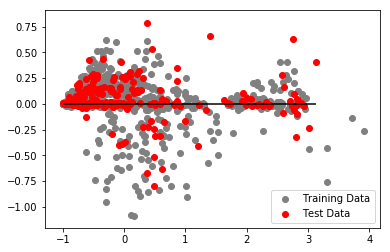

In [117]:
plt.scatter(rfr_pred_train.reshape(-1,1), rfr_pred_train.reshape(-1,1)-y_train, color='gray', label='Training Data')
plt.scatter(rfr_pred.reshape(-1,1), rfr_pred.reshape(-1,1) - y_test, color='red', label='Test Data')
plt.hlines(y=0, xmin=rfr_pred.min(), xmax=rfr_pred.max())
plt.legend()
plt.show()

In [118]:
from sklearn.metrics import mean_squared_error
multilf_mse = mean_squared_error(y_test, multilr_pred)
multilf_mse_train = mean_squared_error(y_train, multilr_pred_train)

polylr_mse = mean_squared_error(y_test, poly_pred)
polylr_mse_train = mean_squared_error(y_train, poly_pred_train)

svr_mse = mean_squared_error(y_test, svr_pred)
svr_mse_train = mean_squared_error(y_train, svr_pred_train)

dtr_mse = mean_squared_error(y_test, dtr_pred)
dtr_mse_train = mean_squared_error(y_train, dtr_pred_train)

rfr_mse = mean_squared_error(y_test, rfr_pred)
rfr_mse_train = mean_squared_error(y_train, rfr_pred_train)

print("""Multivariate Linear Regression:
Polynomial Linear Regression: 
train: {}
test: {}

Support Vector Regression: 
train: {}
test: {}

Decision Tree Regression: 
train: {}
test: {}

Random Forest Regression: 
train: {}
test: {}
""".format(multilf_mse_train, multilf_mse, 
           polylr_mse_train, polylr_mse, 
           svr_mse_train, svr_mse,
           dtr_mse_train, dtr_mse,
           rfr_mse_train, rfr_mse))

Multivariate Linear Regression:
Polynomial Linear Regression: 
train: 0.2572732454200602
test: 0.2171922298936889

Support Vector Regression: 
train: 0.06998374201279665
test: 0.061768393595230675

Decision Tree Regression: 
train: 0.15950324015265005
test: 0.11439438992976278

Random Forest Regression: 
train: 0.0016666827576445652
test: 4.641607369910991e-09



In [119]:
results_df = pd.DataFrame({
    'Regression': ['Multivariate Linear',
                  'Polynomial Linear',
                  'Support Vector',
                  'Decision Tree',
                  'Random Forest'],
    'R2_Score_train': [multilr_score_train,
                polylr_score_train,
                svr_score_train,
                dtr_score_train,
                rfr_score_train],
    'R2_Score_test': [multilr_score,
                polylr_score,
                svr_score,
                dtr_score,
                rfr_score],
    'MSE_train': [multilf_mse_train, 
             polylr_mse_train, 
             svr_mse_train, 
             dtr_mse_train, 
             rfr_mse_train],
    'MSE_test': [multilf_mse, 
         polylr_mse, 
         svr_mse, 
         dtr_mse, 
         rfr_mse]
})
results_df.round(decimals=6)

,Regression,R2_Score_train,R2_Score_test,MSE_train,MSE_test
0,Multivariate Linear,0.737026,0.799988,0.257273,0.217192
1,Polynomial Linear,0.928466,0.943117,0.069984,0.061768
2,Support Vector,0.836963,0.894654,0.159503,0.114394
3,Decision Tree,0.998296,1.000000,0.001667,0.000000
4,Random Forest,0.965413,0.973133,0.033838,0.029174


WOW! Decision Tree Regression is an awesome regression model for this data!